In [2]:
import numpy as np 
import pandas
import matplotlib.pyplot as plt 
import seaborn as sea
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier


In [3]:
X = pandas.read_csv("../input/titanic/train.csv")
Y = pandas.read_csv("../input/titanic/test.csv")
X["training_data"] = 1
Y["training_data"] = 0
Y["Survived"] = np.NaN
combined_data = pandas.concat([X, Y])
print(combined_data.columns)
X.describe()



Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'training_data'],
      dtype='object')


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,training_data
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


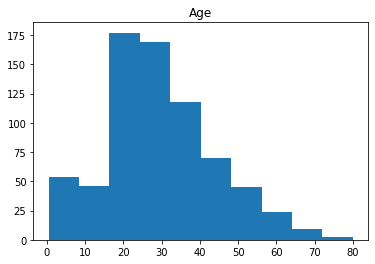

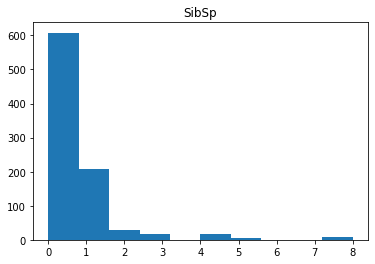

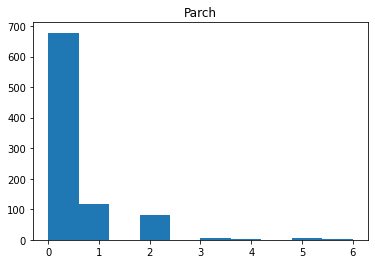

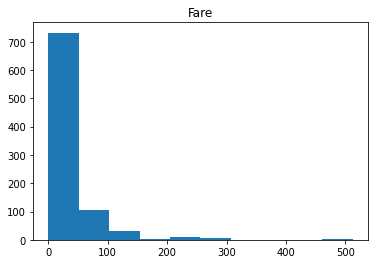

In [4]:
numerical_columns = ["Age", "SibSp", "Parch", "Fare"]
categorical_columns = ["Survived", "Sex", "Pclass", "Ticket", "Cabin", "Embarked"]

for column in numerical_columns:
    plt.hist(X[column])
    plt.title(column)
    plt.show()
   


            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


<AxesSubplot:>

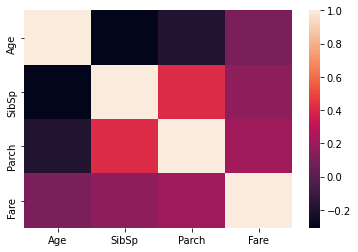

In [5]:
print(X[numerical_columns].corr())
sea.heatmap(X[numerical_columns].corr())

In [6]:
pandas.pivot_table(X, index = "Survived", values = numerical_columns)

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


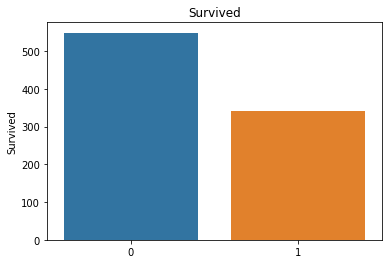

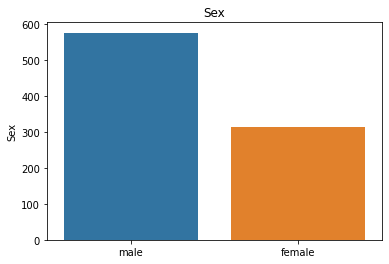

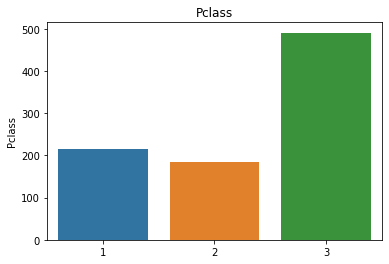

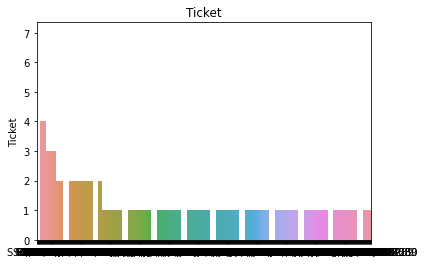

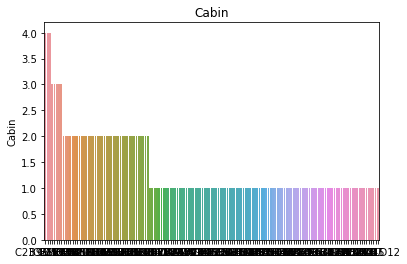

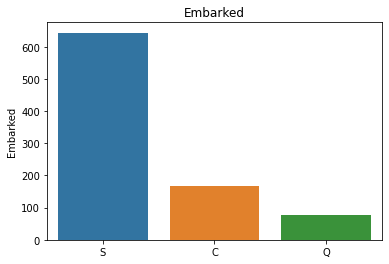

In [7]:
for column in categorical_columns:
    sea.barplot(x = X[column].value_counts().index, y = X[column].value_counts()).set_title(column)
    plt.show()

In [8]:
print(pandas.pivot_table(X, index = "Survived", columns = "Pclass", values = "Ticket", aggfunc = "count"), "/n")
print(pandas.pivot_table(X, index = "Survived", columns = "Sex", values = "Ticket", aggfunc = "count"), "/n")
print(pandas.pivot_table(X, index = "Survived", columns = "Embarked", values = "Ticket", aggfunc = "count"))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119 /n
Sex       female  male
Survived              
0             81   468
1            233   109 /n
Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


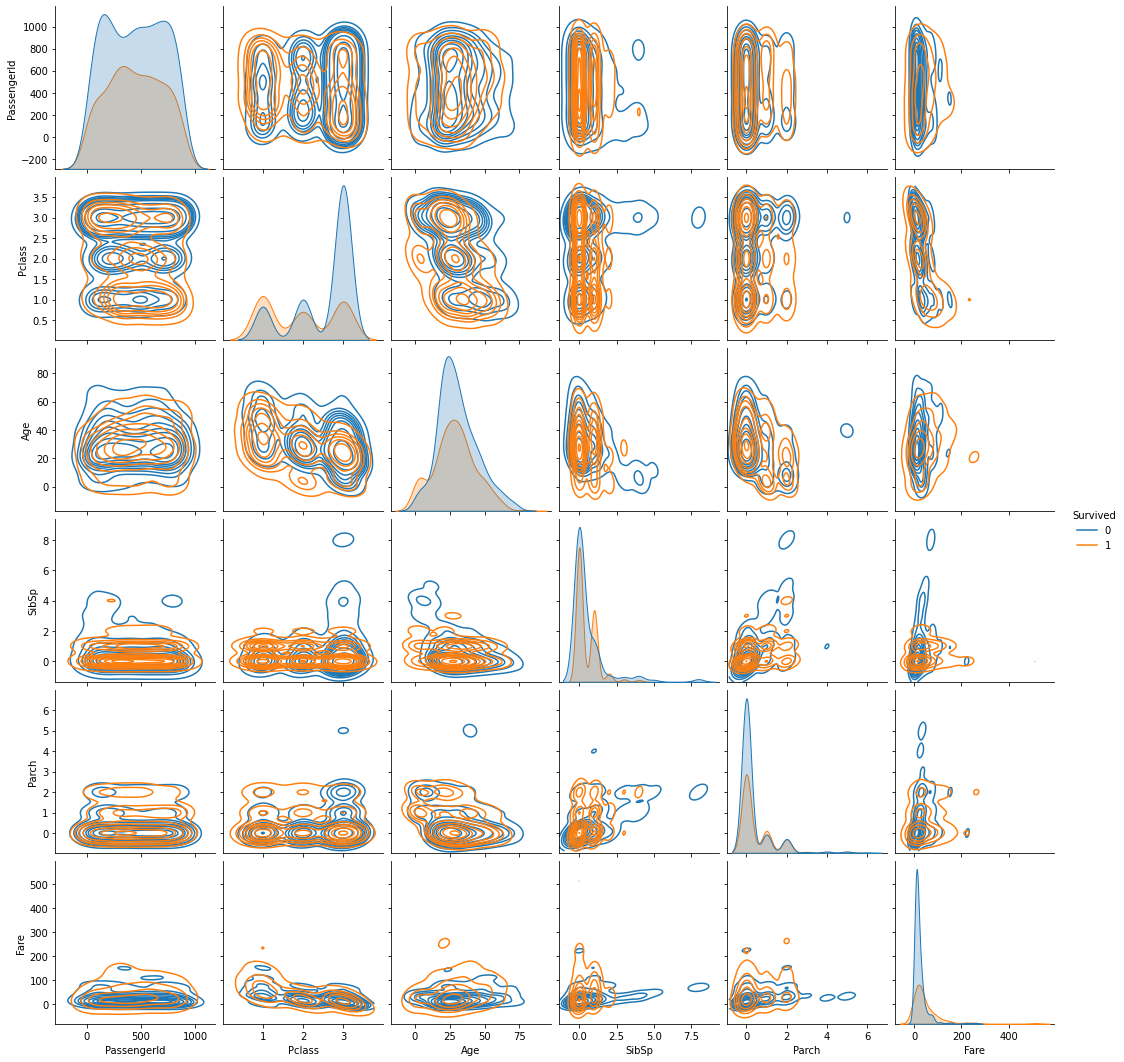

In [10]:
sea.pairplot(X.drop(columns = ["training_data"], inplace = False), hue = "Survived", kind = "kde")

In [11]:
X["total_cabins"] = X.Cabin.apply(lambda x: 0 if pandas.isna(x) else len(x.split(' ')))

print(X["total_cabins"].value_counts())
pandas.pivot_table(X, index = "Survived", columns = "total_cabins", values = "PassengerId", aggfunc = "count")


0    687
1    180
2     16
3      6
4      2
Name: total_cabins, dtype: int64


total_cabins,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


In [12]:
X["cabin_initials"] = X.Cabin.apply(lambda x: str(x)[0])

print(X["cabin_initials"].value_counts())
pandas.pivot_table(X, index = "Survived", columns = "cabin_initials", values = "PassengerId", aggfunc = "count")

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_initials, dtype: int64


cabin_initials,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


In [15]:
X["numeric_ticket"] = X.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
X["lettered_ticket"] = X.Ticket.apply(lambda x: ''.join(x.split(' ')[: -1]).replace('.', '').replace('/', '').lower() if len(x.split(' ')[: -1]) else 0)

In [16]:
X["numeric_ticket"].value_counts()


1    661
0    230
Name: numeric_ticket, dtype: int64

In [17]:
X["lettered_ticket"].value_counts()

0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
c              5
fcc            5
pp             3
wep            3
sopp           3
scah           2
ppp            2
swpp           2
sotono2        2
sca4           1
scahbasle      1
sp             1
fa             1
as             1
sc             1
fc             1
casoton        1
scow           1
sop            1
Name: lettered_ticket, dtype: int64

In [18]:
pandas.pivot_table(X, index = "Survived", columns = "numeric_ticket", values = "PassengerId", aggfunc = "count")

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [19]:
pandas.pivot_table(X, index = "Survived", columns = "lettered_ticket", values = "PassengerId", aggfunc = "count")


lettered_ticket,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,...,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,...,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,...,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0


In [20]:
X["name_title"] = X.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
X["name_title"].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Don               1
the Countess      1
Lady              1
Sir               1
Jonkheer          1
Capt              1
Ms                1
Mme               1
Name: name_title, dtype: int64

In [21]:
pandas.pivot_table(X, index = "Survived", columns = "name_title", values = "PassengerId", aggfunc = "count")

name_title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Survived,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,4.0,1.0,NaN,1.0,17.0,55.0,NaN,NaN,436.0,26.0,NaN,6.0,NaN,NaN
1,NaN,1.0,NaN,3.0,NaN,1.0,1.0,23.0,127.0,2.0,1.0,81.0,99.0,1.0,NaN,1.0,1.0


In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      891 non-null    int64  
 1   Survived         891 non-null    int64  
 2   Pclass           891 non-null    int64  
 3   Name             891 non-null    object 
 4   Sex              891 non-null    object 
 5   Age              714 non-null    float64
 6   SibSp            891 non-null    int64  
 7   Parch            891 non-null    int64  
 8   Ticket           891 non-null    object 
 9   Fare             891 non-null    float64
 10  Cabin            204 non-null    object 
 11  Embarked         889 non-null    object 
 12  training_data    891 non-null    int64  
 13  total_cabins     891 non-null    int64  
 14  cabin_initials   891 non-null    object 
 15  numeric_ticket   891 non-null    int64  
 16  lettered_ticket  891 non-null    object 
 17  name_title      

<AxesSubplot:>

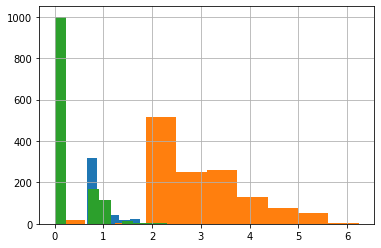

In [23]:
combined_data["name_title"] = combined_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
combined_data["numeric_ticket"] = combined_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
combined_data["lettered_ticket"] = combined_data.Ticket.apply(lambda x: ''.join(x.split(' ')[: -1]).replace('.', '').replace('/', '').lower() if len(x.split(' ')[: -1]) else 0)
combined_data["cabin_initials"] = combined_data.Cabin.apply(lambda x: str(x)[0])
combined_data["total_cabins"] = combined_data.Cabin.apply(lambda x: 0 if pandas.isna(x) else len(x.split(' ')))

combined_data["Age"] = combined_data["Age"].fillna(X["Age"].mean())
combined_data["Fare"] = combined_data["Fare"].fillna(X["Fare"].median())
combined_data.dropna(subset = ["Embarked"], inplace = True)

combined_data["norm_sibsp"] = np.log(combined_data["SibSp"] + 1)
combined_data["norm_sibsp"].hist()

combined_data["norm_fare"] = np.log(combined_data["Fare"] + 1)
combined_data["norm_fare"].hist()

combined_data["norm_parch"] = np.log(combined_data["Parch"] + 1)
combined_data["norm_parch"].hist()




In [24]:
onehot_encoder = OneHotEncoder(handle_unknown = "ignore", sparse = False)

encoded_data = pandas.DataFrame(onehot_encoder.fit_transform(combined_data[["Embarked", "Sex", "cabin_initials"]]))
encoded_data.index = combined_data.index
combined_data = pandas.concat([combined_data, encoded_data], axis = 1)

combined_data.drop(columns = ["PassengerId", "Name", "Parch", "SibSp", "Cabin", "Ticket", "name_title", "Fare", "Embarked", "Sex", "cabin_initials", "lettered_ticket"], inplace = True)

X_train = combined_data[combined_data["training_data"] == 1].drop(["training_data", "Survived"], axis = 1)
X_test = combined_data[combined_data["training_data"] == 0].drop(["training_data", "Survived"], axis = 1)

y_train = combined_data[combined_data["training_data"] == 1]["Survived"]
print(y_train.shape)

combined_data.head()

(889,)


,Survived,Pclass,Age,training_data,numeric_ticket,total_cabins,norm_sibsp,norm_fare,norm_parch,0,...,4,5,6,7,8,9,10,11,12,13
0,0.0,3,22.0,1,0,0,0.693147,2.110213,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1,38.0,1,0,1,0.693147,4.280593,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3,26.0,1,0,0,0.000000,2.188856,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1,35.0,1,1,1,0.693147,3.990834,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3,35.0,1,1,0,0.000000,2.202765,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
scaler = StandardScaler()
scaled_data = combined_data.copy()
scaled_data[["Pclass", "Age", "norm_sibsp", "norm_parch", "norm_fare"]] = scaler.fit_transform(scaled_data[["Pclass", "Age", "norm_sibsp", "norm_parch", "norm_fare"]])

X_train_scaled = scaled_data[scaled_data["training_data"] == 1].drop(columns = ["training_data", "Survived"])
X_test_scaled = scaled_data[scaled_data["training_data"] == 0].drop(columns = ["training_data", "Survived"])
X_train_scaled.head()


,Pclass,Age,numeric_ticket,total_cabins,norm_sibsp,norm_fare,norm_parch,0,1,2,...,4,5,6,7,8,9,10,11,12,13
0,0.840447,-0.607808,0,0,0.930628,-0.896331,-0.519295,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.550118,0.636788,0,1,0.930628,1.347870,-0.519295,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.840447,-0.296659,0,0,-0.616256,-0.815013,-0.519295,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.550118,0.403426,1,1,0.930628,1.048255,-0.519295,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.840447,0.403426,1,0,-0.616256,-0.800632,-0.519295,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
gnb = GaussianNB()
validation_score = cross_val_score(gnb, X_train_scaled, y_train, cv = 5)
print(validation_score, validation_score.mean())

[0.66853933 0.67977528 0.71348315 0.7247191  0.77966102] 0.7132355741763474


In [27]:
dtc = tree.DecisionTreeClassifier(random_state = 2)
validation_score = cross_val_score(dtc, X_train, y_train, cv = 5)
print(validation_score, validation_score.mean())


[0.74719101 0.76966292 0.80898876 0.74719101 0.83050847] 0.780708436488288


In [28]:
lr = LogisticRegression(max_iter = 2000)
validation_score = cross_val_score(lr, X_train, y_train, cv = 5)
print(validation_score, validation_score.mean())

[0.78089888 0.81460674 0.78089888 0.78089888 0.81355932] 0.794172538564083


In [29]:
lr = LogisticRegression(max_iter = 2000)
validation_score = cross_val_score(lr, X_train_scaled, y_train, cv = 5)
print(validation_score, validation_score.mean())

[0.7752809  0.80898876 0.78651685 0.78089888 0.81920904] 0.79417888656129


In [30]:
knn = KNeighborsClassifier()
validation_score = cross_val_score(knn, X_train, y_train, cv = 5)
print(validation_score, validation_score.mean())

[0.74157303 0.78089888 0.76966292 0.8258427  0.81355932] 0.7863073700247573


In [31]:
knn = KNeighborsClassifier()
validation_score = cross_val_score(knn, X_train_scaled, y_train, cv = 5)
print(validation_score, validation_score.mean())

[0.7752809  0.78089888 0.79775281 0.78651685 0.83615819] 0.7953215260585285


In [32]:
rfc = RandomForestClassifier(random_state = 2)
validation_score = cross_val_score(rfc, X_train, y_train, cv = 5)
print(validation_score, validation_score.mean())

[0.78651685 0.79213483 0.8258427  0.74719101 0.83050847] 0.7964387735669397


In [33]:
rfc = RandomForestClassifier(random_state = 2)
validation_score = cross_val_score(rfc, X_train_scaled, y_train, cv = 5)
print(validation_score, validation_score.mean())

[0.78651685 0.79213483 0.8258427  0.74719101 0.83050847] 0.7964387735669397


In [34]:
svc = SVC(probability = True)
validation_score = cross_val_score(svc, X_train, y_train, cv = 5)
print(validation_score, validation_score.mean())

[0.66292135 0.74719101 0.69101124 0.71348315 0.73446328] 0.7098140036818383


In [35]:
svc = SVC(probability = True)
validation_score = cross_val_score(svc, X_train_scaled, y_train, cv = 5)
print(validation_score, validation_score.mean())

[0.81460674 0.81460674 0.82022472 0.79775281 0.84745763] 0.8189297276709198


In [36]:
xgb = XGBClassifier(random_state = 2, use_label_encoder=False, verbosity = 0)
validation_score = cross_val_score(xgb, X_train_scaled, y_train, cv = 5)
print(validation_score, validation_score.mean())

[0.78089888 0.80898876 0.87640449 0.78651685 0.83615819] 0.8177934361708882


In [37]:
voting_clf = VotingClassifier(estimators = [("Logistic Regression", lr), ("KNearestNeighbour", knn), ("Random Forest", rfc), ("GaussianNB", gnb), ("SVC", svc), ("XGBoost Classifier", xgb)], voting = "soft")
validation_score = cross_val_score(voting_clf, X_train_scaled, y_train, cv = 5)
print(validation_score, validation_score.mean())

[0.80898876 0.80898876 0.81460674 0.80898876 0.85310734] 0.8189360756681265


In [38]:
voting_clf.fit(X_train_scaled, y_train)
base_prediction = voting_clf.predict(X_test_scaled).astype(int)
basic_submission = {"PassengerId": Y["PassengerId"], "Survived": base_prediction}
base_submission = pandas.DataFrame(data = basic_submission)
base_submission.to_csv("base_submission.csv", index = False)

In [39]:
def performance_stats(classifier, model_name):
    print(model_name)
    print(f"Best Score: {classifier.best_score_}")
    print(f"Best Performance: {classifier.best_params_}")

In [40]:
lr = LogisticRegression()
grid_params = {
    "max_iter": [2000],
    "penalty": ['l1', 'l2'],
    "C": np.logspace(-4, 4, 20),
    "solver": ["liblinear"]
}
lr_clf = GridSearchCV(lr, param_grid = grid_params, cv = 5, verbose = True, n_jobs = -1)
best_lr_clf = lr_clf.fit(X_train_scaled, y_train)
performance_stats(best_lr_clf, "Logistic Regression")

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.5s


Logistic Regression
Best Score: 0.7930489430584651
Best Performance: {'C': 0.23357214690901212, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.2s finished


In [41]:
knn = KNeighborsClassifier()
grid_params = {
    "n_neighbors": [3, 4, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree"],
    "p": [1, 2, 3]
}
knn_clf = GridSearchCV(knn, param_grid = grid_params, cv = 5, verbose = True, n_jobs = -1)
best_knn_clf = knn_clf.fit(X_train_scaled, y_train)
performance_stats(best_knn_clf, "KNN")

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.4s


KNN
Best Score: 0.8031866945978544
Best Performance: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    5.7s finished


In [42]:
svc = SVC(probability = True)
grid_params = tuned_parameters = [
    {
        'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
        'C': [.1, 1, 10, 100, 1000]
    },
    {
        'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]
    },
    {
        'kernel': ['poly'], 'degree' : [2,3,4,5], 
        'C': [.1, 1, 10, 100, 1000]
    }
]
svc_clf = GridSearchCV(svc, param_grid = grid_params, cv = 5, verbose = True, n_jobs = -1)
best_svc_clf = svc_clf.fit(X_train_scaled, y_train)
performance_stats(best_svc_clf, "SVC")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:  8.0min


SVC
Best Score: 0.8189360756681268
Best Performance: {'C': 1, 'degree': 2, 'kernel': 'poly'}


[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed: 11.7min finished


In [43]:
rfc = RandomForestClassifier(random_state = 2)
grid_params = {
    "n_estimators" : [100, 500, 1000],
    "bootstrap": [True, False],
    "max_depth": [3, 5, 10, 20, 50, 75, None],
    "max_features": ["auto", "sqrt"], 
    "min_samples_leaf": [1, 2, 4, 10],
    "min_samples_split": [2, 5, 10]
}
random_rfc_clf = RandomizedSearchCV(rfc, param_distributions = grid_params, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
best_rfc_clf = random_rfc_clf.fit(X_train_scaled, y_train)
performance_stats(best_rfc_clf, "Random Forest")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.3min finished


Random Forest
Best Score: 0.8245604011934236
Best Performance: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}


In [44]:
rfc2 = RandomForestClassifier(random_state = 2)
grid_params = {
    "n_estimators": [400, 450, 500, 550],
    "criterion": ["gini", "entropy"], 
    "bootstrap": [True], 
    "max_depth": [15, 20, 25],
    "max_features": ["auto", "sqrt", 10],
    "min_samples_leaf": [2, 3], 
    "min_samples_split": [2, 3]
}
rfc2_clf = GridSearchCV(rfc2, param_grid = grid_params, cv = 5, verbose = True, n_jobs = -1)
best_rfc2_clf = rfc2_clf.fit(X_train_scaled, y_train)
performance_stats(best_rfc2_clf, "Random Forest")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 10.5min finished


Random Forest
Best Score: 0.8335555132355742
Best Performance: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 500}


<AxesSubplot:>

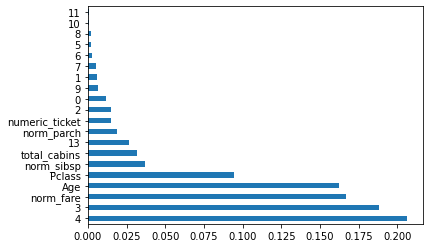

In [45]:
best_rfc = best_rfc2_clf.best_estimator_.fit(X_train_scaled, y_train)
feature_importance = pandas.Series(best_rfc.feature_importances_, index = X_train_scaled.columns)
feature_importance.nlargest(20).plot(kind = "barh")

In [ ]:
# Takes too long to train
# xgb = XGBClassifier(random_state = 2, verbosity = 0)
# grid_params = {
#     "n_estimators": [450, 500, 550], 
#     "colsample_bytree": [0.75, 0.8, 0.85],
#     "max_depth": [None], 
#     "reg_alpha": [1],
#     "reg_lambda": [2, 5, 10], 
#     "subsample": [0.55, 0.6, 0.65], 
#     "learning_rate": [0.5], 
#     "gamma": [0.5, 1, 2], 
#     "min_child_weight": [0.01],
#     "sampling_method": ["uniform"]
# }

# xgb_clf = GridSearchCV(xgb, param_grid = grid_params, cv = 5, verbose = True, n_jobs = -1)
# best_xgb_clf = xgb_clf.fit(X_train_scaled, y_train)

# performance_stats(best_xgb_clf,  "XGB")

In [ ]:
# The above takes a really long time to train 
# xgb_prediction = best_xgb_clf.best_estimator_.predict(X_test_scaled).astype(int)
# xgb_submission = {
#     "PassengerId": Y["PassengerId"],
#     "Survived": xgb_prediction
# }
# xgb_submission_file = pandas.DataFrame(data = xgb_submission)
# xgb_submission_file.to_csv("xgb_submission.csv", index = False)

In [46]:
best_lr = best_lr_clf.best_estimator_
best_knn = best_knn_clf.best_estimator_
best_svc = best_svc_clf.best_estimator_
best_rf = best_rfc2_clf.best_estimator_
# best_xgb = best_xgb_clf.best_estimator_

voting_clf_hard = VotingClassifier(estimators = [("KNN", best_knn), ("Random Forest", best_rf), ("SVC", best_svc)], voting = "hard")
voting_clf_soft = VotingClassifier(estimators = [("KNN", best_knn), ("Random Forest", best_rf), ("SVC", best_svc)], voting = "soft")
voting_clf_all = VotingClassifier(estimators = [("KNN", best_knn), ("Random Forest", best_rf), ("SVC", best_svc), ("Logistic Regression", best_lr)], voting = "soft")
# voting_clf_xgb = VotingClassifier(estimators = [("KNN", best_knn), ("Random Forest", best_rf), ("SVC", best_svc), ("Logistic Regression", best_lr), ("XGB", best_xgb)], voting = "soft")

validation_score_soft = cross_val_score(voting_clf_soft, X_train_scaled, y_train, cv = 5)
print("Voting_soft: ", validation_score_soft)
print("Mean: ", validation_score_soft.mean())

validation_score_hard = cross_val_score(voting_clf_hard, X_train_scaled, y_train, cv = 5)
print("Voting_hard: ", validation_score_hard)
print("Mean: ", validation_score_hard.mean())

validation_score_all = cross_val_score(voting_clf_all, X_train_scaled, y_train, cv = 5)
print("Voting_all: ", validation_score_all)
print("Mean: ", validation_score_all.mean())

# validation_score_xgb = cross_val_score(voting_clf_xgb, X_train_scaled, y_train, cv = 5)
# print("Voting_xgb: ", validation_score_xgb)
# print("Mean: ", validation_score_xgb.mean())

Voting_soft:  [0.78651685 0.80898876 0.8258427  0.79213483 0.84745763]
Mean:  0.812188154637212
Voting_hard:  [0.80898876 0.79775281 0.82022472 0.79775281 0.84745763]
Mean:  0.8144353456484478
Voting_all:  [0.80337079 0.81460674 0.82022472 0.79775281 0.84745763]
Mean:  0.8166825366596839


In [47]:
grid_params = {
    "weights": [[1, 1, 1], [1 ,2 ,1], [1, 1 ,2], [2 ,1 ,1], [2 ,2 ,1], [1 ,2 ,2], [2 ,1 ,2]]
}

voting_weights = GridSearchCV(voting_clf_soft, param_grid = grid_params, cv = 5, verbose = True, n_jobs = -1)
best_weights_clf = voting_weights.fit(X_train_scaled, y_train)
performance_stats(best_weights_clf, "VC Weights")
voting_sub_clf = best_weights_clf.best_estimator_.predict(X_test_scaled)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   17.5s finished


VC Weights
Best Score: 0.8166888846568907
Best Performance: {'weights': [1, 1, 2]}


In [48]:
voting_clf_hard.fit(X_train_scaled, y_train)
best_weights_clf.best_estimator_.fit(X_train_scaled, y_train)
voting_clf_all.fit(X_train_scaled, y_train) 
# voting_clf_xgb.fit(X_train_scaled, y_train)
best_rfc.fit(X_train_scaled, y_train) 

hard_predictions = voting_clf_hard.predict(X_test_scaled).astype(int)
soft_predictions = best_weights_clf.predict(X_test_scaled).astype(int)
all_predictions = voting_clf_all.predict(X_test_scaled).astype(int)
# xgb_predictions = voting_clf_xgb.predict(X_test_scaled).astype(int)
rfc_predictions = best_rfc.predict(X_test_scaled).astype(int)


In [51]:
data1 = {"PassengerId": Y["PassengerId"], "Survived": rfc_predictions}
submission1 = pandas.DataFrame(data = data1)

data2 = {"PassengerId": Y["PassengerId"], "Survived": hard_predictions}
submission2 = pandas.DataFrame(data = data2)

data3 = {"PassengerId": Y["PassengerId"], "Survived": soft_predictions}
submission3 = pandas.DataFrame(data = data3)

data4 = {"PassengerId": Y["PassengerId"], "Survived": all_predictions}
submission4 = pandas.DataFrame(data = data4)

# data5 = {"PassengerId": Y["PassengerId"], "Survived": xgb_predictions}
# submission5 = pandas.DataFrame(data = data5)

submission1.to_csv("rfc_submission.csv", index = False)
submission2.to_csv("hard_submission.csv", index = False)
submission3.to_csv("soft_submission.csv", index = False)
submission4.to_csv("all_submission.csv", index = False)
# submission5.to_csv("xgb2_submission.csv", index = False)

